<center><h1>HW 2: Logistic regression</h1></center>

Импортирую библиотеки

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy.stats as stats

%matplotlib notebook
import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

Задаю генеральные совокупности

In [2]:
params = [[torch.zeros(2), torch.eye(2)],
          [torch.tensor([7., 3.4]), torch.eye(2)*4]]

In [3]:
d0 = torch.distributions.MultivariateNormal(params[0][0], params[0][1])
d1 = torch.distributions.MultivariateNormal(params[1][0], params[1][1])

Создание выборки из генеральной совокупности

In [4]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

Подготовка данных для отрисовки графика

In [5]:
def get_prepared_base_distributions(X, Y, params, dist=None):
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    Z0 = stats.multivariate_normal(params[0][0], params[0][1]).pdf(pos)
    Z1 = stats.multivariate_normal(params[1][0], params[1][1]).pdf(pos)
    if dist is not None:
        Z = dist.flatten().reshape(500, 500)
    else:
        Z  = None
    return Z0, Z1, Z

Отрисовка плоского графика

In [16]:
def plt_contour_func(list_of_z):
    x_scale = np.linspace(-10, 10, 500)
    y_scale = np.linspace(-10, 10, 500)
    X, Y = np.meshgrid(x_scale, y_scale)
    plt.figure()
    css = [plt.contour(X, Y, Z) for Z in list_of_z]
    for cs in css:
        plt.clabel(cs, inline=1, fontsize=10)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Flat')

Отрисовываю распределения

<IPython.core.display.Javascript object>


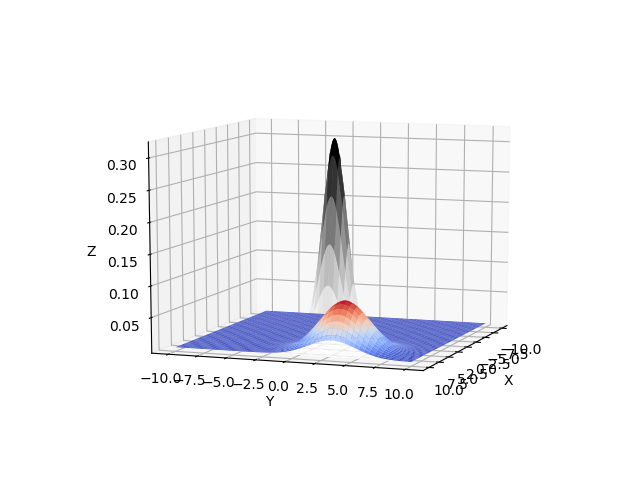

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z0, Z1, Z = get_prepared_base_distributions(X, Y, params)

ax.plot_surface(X, Y, Z0*2, cmap=matplotlib.cm.Greys)
ax.plot_surface(X, Y, Z1*2, cmap=matplotlib.cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(10, 20)
ratio = Z1 / (Z0 + Z1)

plt.show()

Создаю нейронную сеть

In [8]:
net = nn.Sequential(nn.Linear(2, 5), nn.ReLU(), nn.Linear(5, 1))
for p in net.parameters():
    print(p.data)
net_opt = optim.SGD(lr=1e-3, params=list(net.parameters()))

tensor([[ 0.0520,  0.2368],
        [-0.0769,  0.3511],
        [ 0.1818, -0.2127],
        [ 0.0238,  0.0388],
        [ 0.6280, -0.4869]])
tensor([-0.5523, -0.2289,  0.0900,  0.3024,  0.4932])
tensor([[-0.2564,  0.0925,  0.3192,  0.3324, -0.4033]])
tensor([0.1478])


Обучаю нейронную сеть

In [9]:
# Выводим сообщение 1 раз за log_freq шагов
log_freq = 500
# Обучаем нейронную сеть
for i in range(100000):
    # Если пора выводить сообщение, то выводим
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    # Очищаем градиент
    net_opt.zero_grad()
    # Сэмплируем
    x, y = sample(d0, d1, 1024)
    # Предсказываем
    out = net(x)
    # Считаем ошибку
    loss = F.binary_cross_entropy_with_logits(out, y)
    # Делаем обратное распространение ошибки
    loss.backward()
    # Шагаем с помощью выбранного оптимизатора (в нашем случае - SGD)
    net_opt.step()

Ошибка после 0 итераций: 0.979861


/home/andrey/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Ошибка после 1 итераций: 0.484510
Ошибка после 2 итераций: 0.421294
Ошибка после 3 итераций: 0.378116
Ошибка после 4 итераций: 0.343531
Ошибка после 5 итераций: 0.311782
Ошибка после 6 итераций: 0.284827
Ошибка после 7 итераций: 0.260981
Ошибка после 8 итераций: 0.239910
Ошибка после 9 итераций: 0.221553
Ошибка после 10 итераций: 0.204919
Ошибка после 11 итераций: 0.189718
Ошибка после 12 итераций: 0.177529
Ошибка после 13 итераций: 0.164947
Ошибка после 14 итераций: 0.154451
Ошибка после 15 итераций: 0.144049
Ошибка после 16 итераций: 0.136052
Ошибка после 17 итераций: 0.128049
Ошибка после 18 итераций: 0.120857
Ошибка после 19 итераций: 0.113838
Ошибка после 20 итераций: 0.107255
Ошибка после 21 итераций: 0.101345
Ошибка после 22 итераций: 0.096593
Ошибка после 23 итераций: 0.091371
Ошибка после 24 итераций: 0.087060
Ошибка после 25 итераций: 0.082447
Ошибка после 26 итераций: 0.078255
Ошибка после 27 итераций: 0.075060
Ошибка после 28 итераций: 0.071438
Ошибка после 29 итераций: 0.0

Делаю предсказание

In [11]:
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y
x_tensor = torch.tensor(pos, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(net(x_tensor)).numpy()

Визуализирую предсказание

<IPython.core.display.Javascript object>


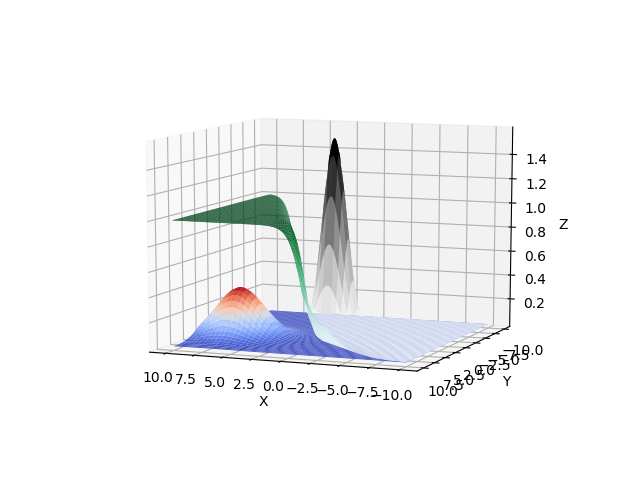

In [13]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(np.linspace(-10, 10, 500), np.linspace(-10, 10, 500))
Z0, Z1, Z = get_prepared_base_distributions(X, Y, params, dist)
ax.plot_surface(X, Y, Z, cmap=cm.BuGn)
ax.plot_surface(X, Y, Z0*10, cmap=matplotlib.cm.Greys)
ax.plot_surface(X, Y, Z1*10, cmap=matplotlib.cm.coolwarm)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(10, 20)
ratio = Z1 / (Z0 + Z1)

plt.show()

<IPython.core.display.Javascript object>


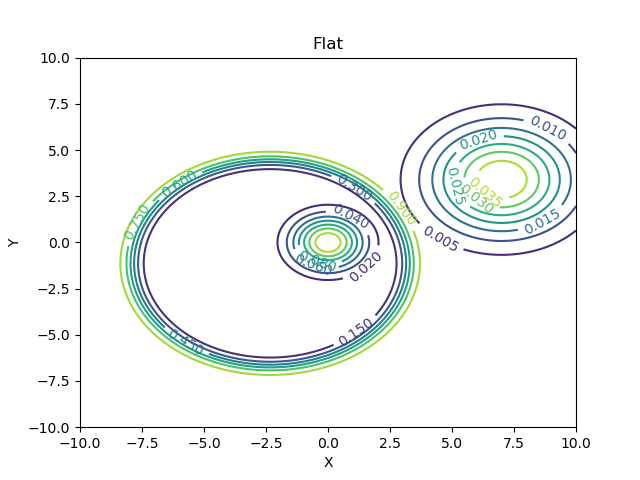

In [17]:
Z = ratio
plt_contour_func([Z, Z0, Z1])

Логистическая регрессия обучена на двумерных данных.
Построены графики исходных распределений и разделяющая гиперплоскость.